# Auswertung 27.05.2025
Auswertung mit vergleich von TBBB TCBC und LNO

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

import glob
import re

def dat2array(file_path):
    data = []
    with open(file_path, 'r', encoding='utf-8') as file:
        for i, line in enumerate(file):
            line = line.replace(',', '.').replace('\t', ';').replace('\n', '')
            if i >= 39:  # Skip header lines
                data.append(line.split(';'))

    freqs = [float(row[0]) for row in data]
    intensities = [float(row[1]) for row in data]
    return freqs, intensities
    

## TBBB

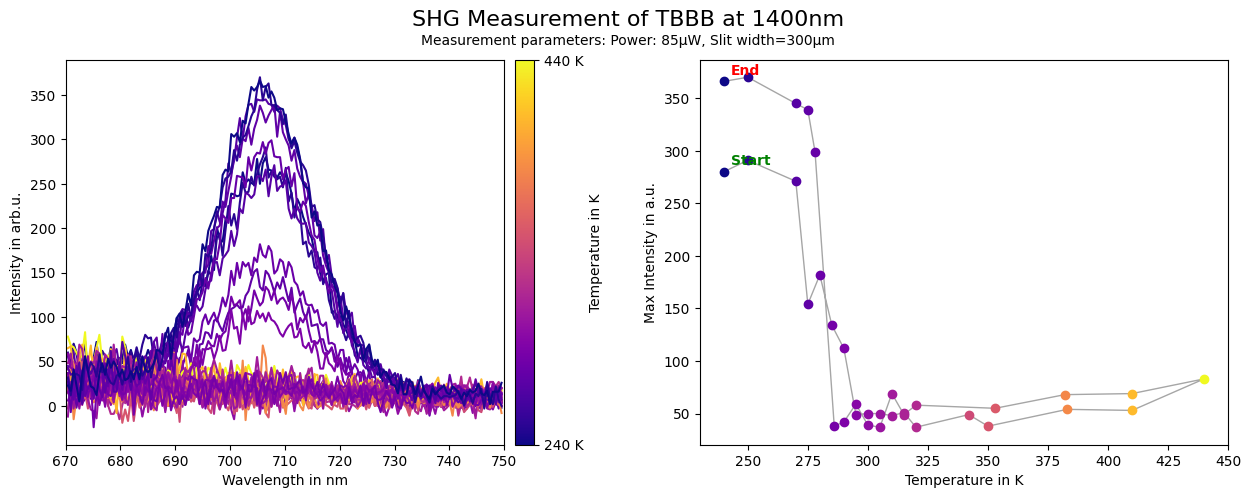

The maximum intensity across all temperatures is: 370.0


In [28]:
# Define the range for the x-axis
middle_value = 710
difference = 40
x_range = (middle_value - difference, middle_value + difference)

file_list = glob.glob('2025-05-22 TBBB/1400nm/0.333mW_Spalt210um/*.asc')

def extract_info(filename):
    match = re.search(r'0(\d+)_(\d+)K\.asc', filename)
    if match:
        return int(match.group(1)), int(match.group(2))
    return None, None

sorted_files = []
for f in file_list:
    meas_no, temperature = extract_info(f)
    if meas_no is not None:
        sorted_files.append((f, meas_no, temperature))


sorted_files.sort(key=lambda x: x[1])  # Nach Messnummer sortieren

# Erzeuge das Farbfeld anhand der Temperaturwerte
temperatures = [x[2] for x in sorted_files]
norm = plt.Normalize(min(temperatures), max(temperatures))
colors = cm.plasma(norm(temperatures))

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(15, 5))
peak_list = []

# Listen für Verbindungslinie im rechten Plot
temps_for_line = []
peaks_for_line = []

for idx, (f, meas_no, temperature) in enumerate(sorted_files):
    freqs, intensities = dat2array(f)
    intensities = [val / 1 for val in intensities]
    filtered_data = [(fr, i) for fr, i in zip(freqs, intensities) if x_range[0] <= fr <= x_range[1]]
    filtered_freqs, filtered_intensities = zip(*filtered_data) if filtered_data else ([], [])
    
    ax0.plot(filtered_freqs, filtered_intensities, color=colors[idx])
    if filtered_intensities:
        peak = max(filtered_intensities)
        peak_list.append(peak)
        ax1.scatter(temperature, peak, color=colors[idx])
        temps_for_line.append(temperature)
        peaks_for_line.append(peak)

# Colorbar für Temperatur
sm = plt.cm.ScalarMappable(cmap=cm.plasma, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax0, orientation='vertical', pad=0.02)
cbar.set_label('Temperature in K')
cbar.set_ticks([min(temperatures), max(temperatures)])
cbar.set_ticklabels([f"{min(temperatures)} K", f"{max(temperatures)} K"])

# Punkte im rechten Plot verbinden (Messreihenfolge)
ax1.plot(temps_for_line, peaks_for_line, color='gray', linewidth=1, alpha=0.7, zorder=0)

# Start- und Endpunkt beschriften
if temps_for_line and peaks_for_line:
    ax1.annotate('Start', xy=(temps_for_line[0], peaks_for_line[0]), xytext=(5, 5), textcoords='offset points', fontsize=10, color='green', fontweight='bold')
    ax1.annotate('End', xy=(temps_for_line[-1], peaks_for_line[-1]), xytext=(5, 5), textcoords='offset points', fontsize=10, color='red', fontweight='bold')

ax0.set_xlim(x_range)
ax0.set_xlabel('Wavelength in nm')
ax0.set_ylabel('Intensity in arb.u.')

ax1.set_xlabel('Temperature in K')
ax1.set_ylabel('Max Intensity in a.u.')

fig.suptitle('SHG Measurement of TBBB at 1400nm', fontsize=16)
fig.text(0.5, 0.91, "Measurement parameters: Power: 85µW, Slit width=300µm", ha="center")
plt.show()
fig.savefig('./TBBB_SHG.png', dpi=600, bbox_inches='tight')
fig.savefig('./TBBB_SHG.pdf', dpi=600, bbox_inches='tight')
# Print the maximum value from the peak_list
print("The maximum intensity across all temperatures is:", max(peak_list))

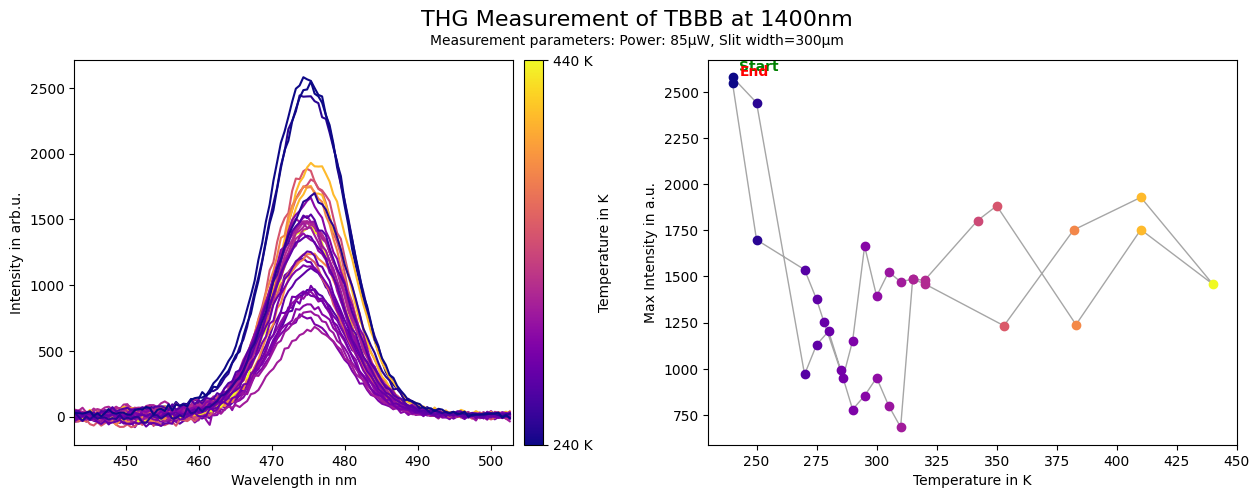

The maximum intensity across all temperatures is: 2580.0


In [29]:
# Define the range for the x-axis
middle_value = 473
difference = 30
x_range = (middle_value - difference, middle_value + difference)

file_list = glob.glob('2025-05-22 TBBB/1400nm/0.333mW_Spalt210um/*.asc')

def extract_info(filename):
    match = re.search(r'0(\d+)_(\d+)K\.asc', filename)
    if match:
        return int(match.group(1)), int(match.group(2))
    return None, None

sorted_files = []
for f in file_list:
    meas_no, temperature = extract_info(f)
    if meas_no is not None:
        sorted_files.append((f, meas_no, temperature))


sorted_files.sort(key=lambda x: x[1])  # Nach Messnummer sortieren

# Erzeuge das Farbfeld anhand der Temperaturwerte
temperatures = [x[2] for x in sorted_files]
norm = plt.Normalize(min(temperatures), max(temperatures))
colors = cm.plasma(norm(temperatures))

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(15, 5))
peak_list = []

# Listen für Verbindungslinie im rechten Plot
temps_for_line = []
peaks_for_line = []

for idx, (f, meas_no, temperature) in enumerate(sorted_files):
    freqs, intensities = dat2array(f)
    intensities = [val / 1 for val in intensities]
    filtered_data = [(fr, i) for fr, i in zip(freqs, intensities) if x_range[0] <= fr <= x_range[1]]
    filtered_freqs, filtered_intensities = zip(*filtered_data) if filtered_data else ([], [])
    
    ax0.plot(filtered_freqs, filtered_intensities, color=colors[idx])
    if filtered_intensities:
        peak = max(filtered_intensities)
        peak_list.append(peak)
        ax1.scatter(temperature, peak, color=colors[idx])
        temps_for_line.append(temperature)
        peaks_for_line.append(peak)

# Colorbar für Temperatur
sm = plt.cm.ScalarMappable(cmap=cm.plasma, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax0, orientation='vertical', pad=0.02)
cbar.set_label('Temperature in K')
cbar.set_ticks([min(temperatures), max(temperatures)])
cbar.set_ticklabels([f"{min(temperatures)} K", f"{max(temperatures)} K"])

# Punkte im rechten Plot verbinden (Messreihenfolge)
ax1.plot(temps_for_line, peaks_for_line, color='gray', linewidth=1, alpha=0.7, zorder=0)

# Start- und Endpunkt beschriften
if temps_for_line and peaks_for_line:
    ax1.annotate('Start', xy=(temps_for_line[0], peaks_for_line[0]), xytext=(5, 5), textcoords='offset points', fontsize=10, color='green', fontweight='bold')
    ax1.annotate('End', xy=(temps_for_line[-1], peaks_for_line[-1]), xytext=(5, 5), textcoords='offset points', fontsize=10, color='red', fontweight='bold')

ax0.set_xlim(x_range)
ax0.set_xlabel('Wavelength in nm')
ax0.set_ylabel('Intensity in arb.u.')

ax1.set_xlabel('Temperature in K')
ax1.set_ylabel('Max Intensity in a.u.')

fig.suptitle('THG Measurement of TBBB at 1400nm', fontsize=16)
fig.text(0.5, 0.91, "Measurement parameters: Power: 85µW, Slit width=300µm", ha="center")
plt.show()
fig.savefig('./TBBB_THG.png', dpi=600, bbox_inches='tight')
fig.savefig('./TBBB_THG.pdf', dpi=600, bbox_inches='tight')
# Print the maximum value from the peak_list
print("The maximum intensity across all temperatures is:", max(peak_list))

## TCBC

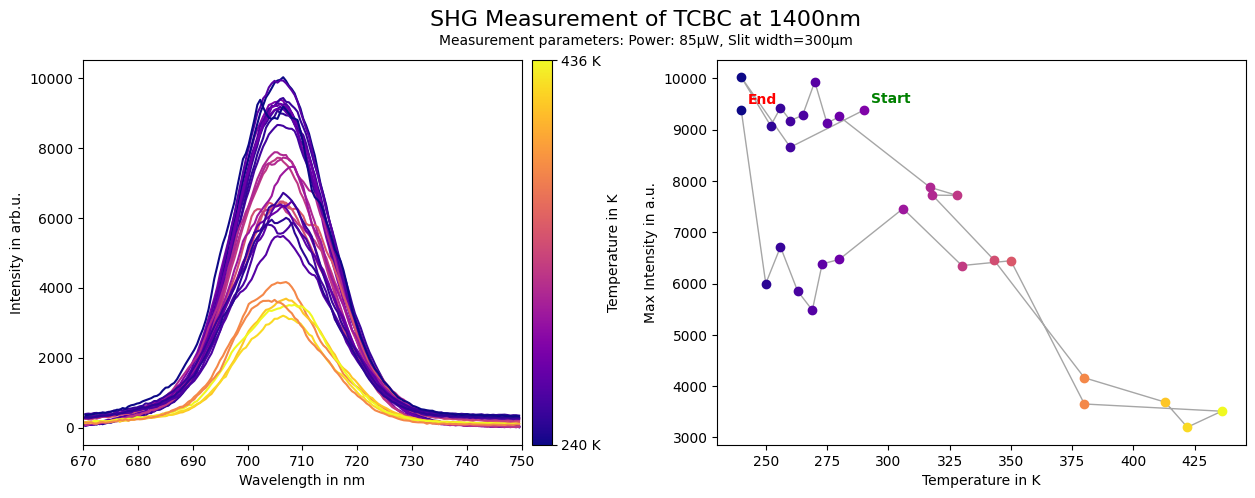

The maximum intensity across all temperatures is: 10023.0


In [30]:
# Define the range for the x-axis
middle_value = 710
difference = 40
x_range = (middle_value - difference, middle_value + difference)

file_list = glob.glob('2025-05-23 TCBC/1400nm/0.333mW_Spalt210um/*.asc')

def extract_info(filename):
    match = re.search(r'0(\d+)_(\d+)K\.asc', filename)
    if match:
        return int(match.group(1)), int(match.group(2))
    return None, None

sorted_files = []
for f in file_list:
    meas_no, temperature = extract_info(f)
    if meas_no is not None:
        sorted_files.append((f, meas_no, temperature))


sorted_files.sort(key=lambda x: x[1])  # Nach Messnummer sortieren

# Erzeuge das Farbfeld anhand der Temperaturwerte
temperatures = [x[2] for x in sorted_files]
norm = plt.Normalize(min(temperatures), max(temperatures))
colors = cm.plasma(norm(temperatures))

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(15, 5))
peak_list = []

# Listen für Verbindungslinie im rechten Plot
temps_for_line = []
peaks_for_line = []

for idx, (f, meas_no, temperature) in enumerate(sorted_files):
    freqs, intensities = dat2array(f)
    intensities = [val / 1 for val in intensities]
    filtered_data = [(fr, i) for fr, i in zip(freqs, intensities) if x_range[0] <= fr <= x_range[1]]
    filtered_freqs, filtered_intensities = zip(*filtered_data) if filtered_data else ([], [])
    
    ax0.plot(filtered_freqs, filtered_intensities, color=colors[idx])
    if filtered_intensities:
        peak = max(filtered_intensities)
        peak_list.append(peak)
        ax1.scatter(temperature, peak, color=colors[idx])
        temps_for_line.append(temperature)
        peaks_for_line.append(peak)

# Colorbar für Temperatur
sm = plt.cm.ScalarMappable(cmap=cm.plasma, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax0, orientation='vertical', pad=0.02)
cbar.set_label('Temperature in K')
cbar.set_ticks([min(temperatures), max(temperatures)])
cbar.set_ticklabels([f"{min(temperatures)} K", f"{max(temperatures)} K"])

# Punkte im rechten Plot verbinden (Messreihenfolge)
ax1.plot(temps_for_line, peaks_for_line, color='gray', linewidth=1, alpha=0.7, zorder=0)

# Start- und Endpunkt beschriften
if temps_for_line and peaks_for_line:
    ax1.annotate('Start', xy=(temps_for_line[0], peaks_for_line[0]), xytext=(5, 5), textcoords='offset points', fontsize=10, color='green', fontweight='bold')
    ax1.annotate('End', xy=(temps_for_line[-1], peaks_for_line[-1]), xytext=(5, 5), textcoords='offset points', fontsize=10, color='red', fontweight='bold')

ax0.set_xlim(x_range)
ax0.set_xlabel('Wavelength in nm')
ax0.set_ylabel('Intensity in arb.u.')

ax1.set_xlabel('Temperature in K')
ax1.set_ylabel('Max Intensity in a.u.')

fig.suptitle('SHG Measurement of TCBC at 1400nm', fontsize=16)
fig.text(0.5, 0.91, "Measurement parameters: Power: 85µW, Slit width=300µm", ha="center")
plt.show()
fig.savefig('./TCBC_SHG.png', dpi=600, bbox_inches='tight')
fig.savefig('./TCBC_SHG.pdf', dpi=600, bbox_inches='tight')
# Print the maximum value from the peak_list
print("The maximum intensity across all temperatures is:", max(peak_list))

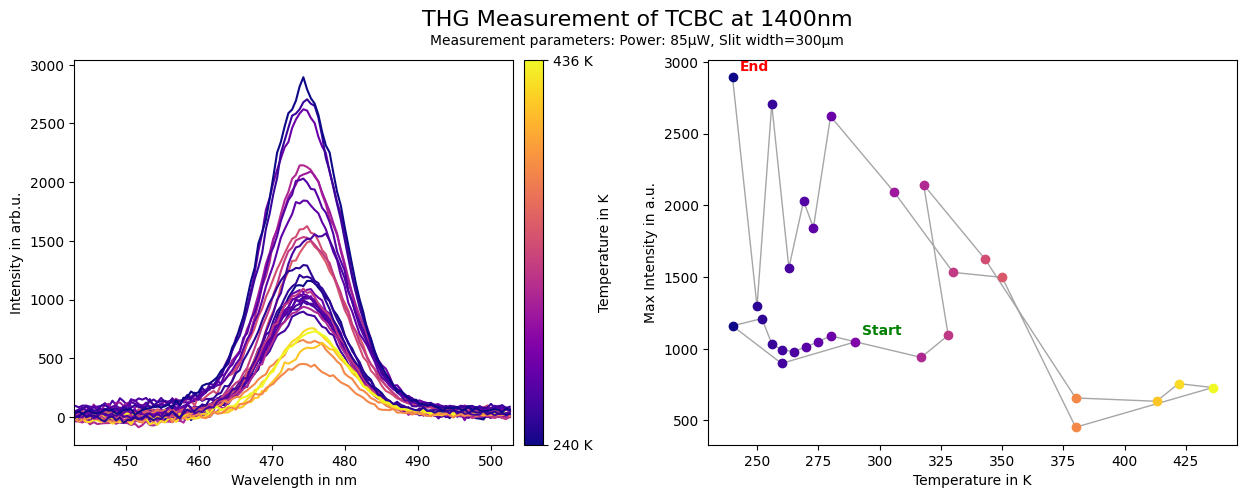

The maximum intensity across all temperatures is: 2894.0


In [31]:
# Define the range for the x-axis
middle_value = 473
difference = 30
x_range = (middle_value - difference, middle_value + difference)

file_list = glob.glob('2025-05-23 TCBC/1400nm/0.333mW_Spalt210um/*.asc')

def extract_info(filename):
    match = re.search(r'0(\d+)_(\d+)K\.asc', filename)
    if match:
        return int(match.group(1)), int(match.group(2))
    return None, None

sorted_files = []
for f in file_list:
    meas_no, temperature = extract_info(f)
    if meas_no is not None:
        sorted_files.append((f, meas_no, temperature))


sorted_files.sort(key=lambda x: x[1])  # Nach Messnummer sortieren

# Erzeuge das Farbfeld anhand der Temperaturwerte
temperatures = [x[2] for x in sorted_files]
norm = plt.Normalize(min(temperatures), max(temperatures))
colors = cm.plasma(norm(temperatures))

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(15, 5))
peak_list = []

# Listen für Verbindungslinie im rechten Plot
temps_for_line = []
peaks_for_line = []

for idx, (f, meas_no, temperature) in enumerate(sorted_files):
    freqs, intensities = dat2array(f)
    intensities = [val / 1 for val in intensities]
    filtered_data = [(fr, i) for fr, i in zip(freqs, intensities) if x_range[0] <= fr <= x_range[1]]
    filtered_freqs, filtered_intensities = zip(*filtered_data) if filtered_data else ([], [])
    
    ax0.plot(filtered_freqs, filtered_intensities, color=colors[idx])
    if filtered_intensities:
        peak = max(filtered_intensities)
        peak_list.append(peak)
        ax1.scatter(temperature, peak, color=colors[idx])
        temps_for_line.append(temperature)
        peaks_for_line.append(peak)

# Colorbar für Temperatur
sm = plt.cm.ScalarMappable(cmap=cm.plasma, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax0, orientation='vertical', pad=0.02)
cbar.set_label('Temperature in K')
cbar.set_ticks([min(temperatures), max(temperatures)])
cbar.set_ticklabels([f"{min(temperatures)} K", f"{max(temperatures)} K"])

# Punkte im rechten Plot verbinden (Messreihenfolge)
ax1.plot(temps_for_line, peaks_for_line, color='gray', linewidth=1, alpha=0.7, zorder=0)

# Start- und Endpunkt beschriften
if temps_for_line and peaks_for_line:
    ax1.annotate('Start', xy=(temps_for_line[0], peaks_for_line[0]), xytext=(5, 5), textcoords='offset points', fontsize=10, color='green', fontweight='bold')
    ax1.annotate('End', xy=(temps_for_line[-1], peaks_for_line[-1]), xytext=(5, 5), textcoords='offset points', fontsize=10, color='red', fontweight='bold')

ax0.set_xlim(x_range)
ax0.set_xlabel('Wavelength in nm')
ax0.set_ylabel('Intensity in arb.u.')

ax1.set_xlabel('Temperature in K')
ax1.set_ylabel('Max Intensity in a.u.')

fig.suptitle('THG Measurement of TCBC at 1400nm', fontsize=16)
fig.text(0.5, 0.91, "Measurement parameters: Power: 85µW, Slit width=300µm", ha="center")
plt.show()
fig.savefig('./TCBC_THG.png', dpi=600, bbox_inches='tight')
fig.savefig('./TCBC_THG.pdf', dpi=600, bbox_inches='tight')
# Print the maximum value from the peak_list
print("The maximum intensity across all temperatures is:", max(peak_list))